In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

In [2]:
from google.colab import files

uploaded = files.upload()

Saving retail_sales_dataset.csv to retail_sales_dataset (4).csv


In [3]:
df = pd.read_csv("retail_sales_dataset.csv")

df.head()

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    1000 non-null   int64 
 1   Date              1000 non-null   object
 2   Customer ID       1000 non-null   object
 3   Gender            1000 non-null   object
 4   Age               1000 non-null   int64 
 5   Product Category  1000 non-null   object
 6   Quantity          1000 non-null   int64 
 7   Price per Unit    1000 non-null   int64 
 8   Total Amount      1000 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 70.4+ KB


In [5]:
df["Date"] = pd.to_datetime(df["Date"])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    1000 non-null   int64         
 1   Date              1000 non-null   datetime64[ns]
 2   Customer ID       1000 non-null   object        
 3   Gender            1000 non-null   object        
 4   Age               1000 non-null   int64         
 5   Product Category  1000 non-null   object        
 6   Quantity          1000 non-null   int64         
 7   Price per Unit    1000 non-null   int64         
 8   Total Amount      1000 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 70.4+ KB


In [6]:
df["Week"] = df["Date"].dt.to_period("W").apply(lambda r: r.start_time)

weekly_demand = (
    df
    .groupby(["Week", "Product Category"])["Quantity"]
    .sum()
    .reset_index()
)

weekly_demand.head()

,Week,Product Category,Quantity
0,2022-12-26,Beauty,3
1,2022-12-26,Clothing,7
2,2023-01-02,Beauty,10
3,2023-01-02,Clothing,15
4,2023-01-02,Electronics,14


In [7]:
category_summary = (
    weekly_demand
    .groupby("Product Category")["Quantity"]
    .sum()
    .sort_values(ascending=False)
)

category_summary

,Quantity
Product Category,
Clothing,894
Electronics,849
Beauty,771


In [8]:
hero_category = "Clothing"

hero_df = weekly_demand[weekly_demand["Product Category"] == hero_category]

hero_df.head()

,Week,Product Category,Quantity
1,2022-12-26,Clothing,7
3,2023-01-02,Clothing,15
6,2023-01-09,Clothing,13
9,2023-01-16,Clothing,11
12,2023-01-23,Clothing,23


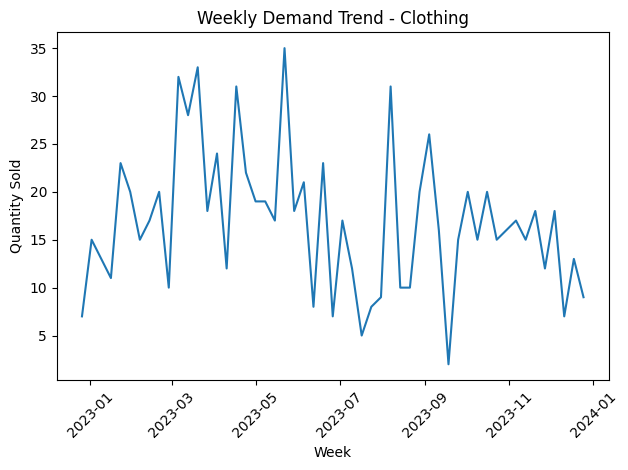

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(hero_df["Week"], hero_df["Quantity"])
plt.title("Weekly Demand Trend - Clothing")
plt.xlabel("Week")
plt.ylabel("Quantity Sold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

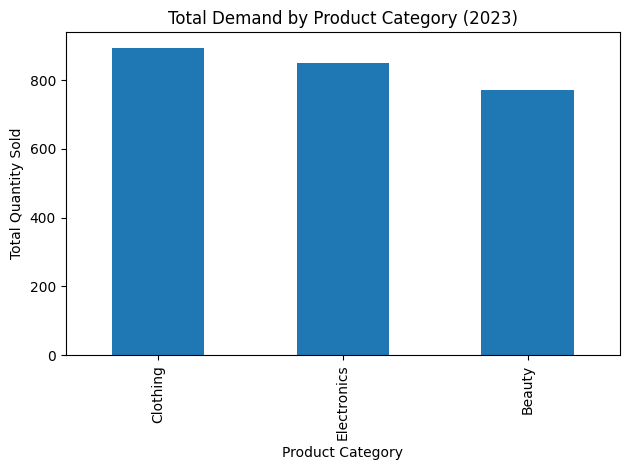

In [10]:
category_summary.plot(kind="bar")
plt.title("Total Demand by Product Category (2023)")
plt.xlabel("Product Category")
plt.ylabel("Total Quantity Sold")
plt.tight_layout()
plt.show()

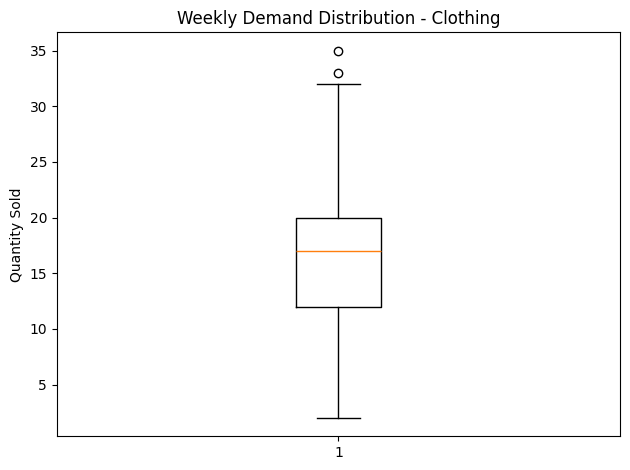

In [11]:
plt.figure()
plt.boxplot(hero_df["Quantity"])
plt.title("Weekly Demand Distribution - Clothing")
plt.ylabel("Quantity Sold")
plt.tight_layout()
plt.show()

In [12]:
hero_df.sort_values("Quantity", ascending=False).head(5)

,Week,Product Category,Quantity
62,2023-05-22,Clothing,35
35,2023-03-20,Clothing,33
30,2023-03-06,Clothing,32
95,2023-08-07,Clothing,31
47,2023-04-17,Clothing,31


In [13]:
hero_df.sort_values("Quantity").head(5)

,Week,Product Category,Quantity
113,2023-09-18,Clothing,2
86,2023-07-17,Clothing,5
77,2023-06-26,Clothing,7
1,2022-12-26,Clothing,7
149,2023-12-11,Clothing,7


In [14]:
ts = hero_df.set_index("Week")["Quantity"]
ts.head()

,Quantity
Week,
2022-12-26,7
2023-01-02,15
2023-01-09,13
2023-01-16,11
2023-01-23,23


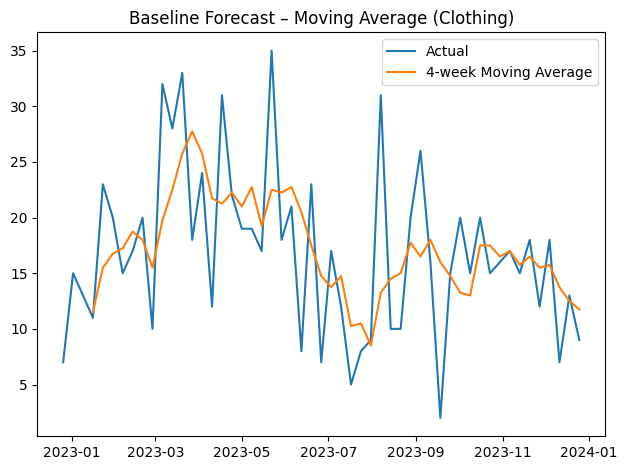

In [15]:
ts_ma = ts.rolling(window=4).mean()

plt.figure()
plt.plot(ts, label="Actual")
plt.plot(ts_ma, label="4-week Moving Average")
plt.title("Baseline Forecast – Moving Average (Clothing)")
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [17]:
clothing_weekly = (
    df[df['Product Category'] == 'Clothing']
    .set_index('Date')
    .resample('W')['Quantity']
    .sum()
)

clothing_weekly.head()

,Quantity
Date,
2023-01-01,7
2023-01-08,15
2023-01-15,13
2023-01-22,11
2023-01-29,23


In [18]:
train_size = int(len(clothing_weekly) * 0.8)
train = clothing_weekly[:train_size]
test = clothing_weekly[train_size:]

In [19]:
model = ExponentialSmoothing(
    train,
    trend='add',
    seasonal=None
)

fit_model = model.fit()

In [20]:
forecast = fit_model.forecast(len(test))

In [21]:
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

mae, rmse

(2.8559151712810897, np.float64(3.5816169234743342))

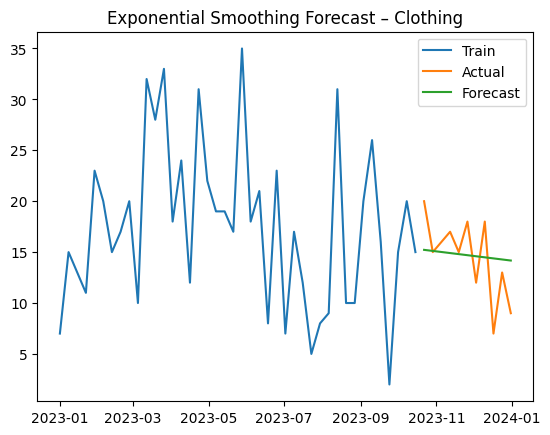

In [22]:
plt.figure()
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast')
plt.legend()
plt.title('Exponential Smoothing Forecast – Clothing')
plt.show()

In [23]:
from statsmodels.tsa.arima.model import ARIMA

In [24]:
clothing_weekly = clothing_weekly.sort_index()

In [25]:
train_size = int(len(clothing_weekly) * 0.8)
train = clothing_weekly[:train_size]
test = clothing_weekly[train_size:]

In [26]:
arima_model = ARIMA(train, order=(1,1,1))
arima_fit = arima_model.fit()

In [27]:
arima_forecast = arima_fit.forecast(steps=len(test))

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

arima_mae = mean_absolute_error(test, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))

arima_mae, arima_rmse

(3.023443026430584, np.float64(3.867399883942795))

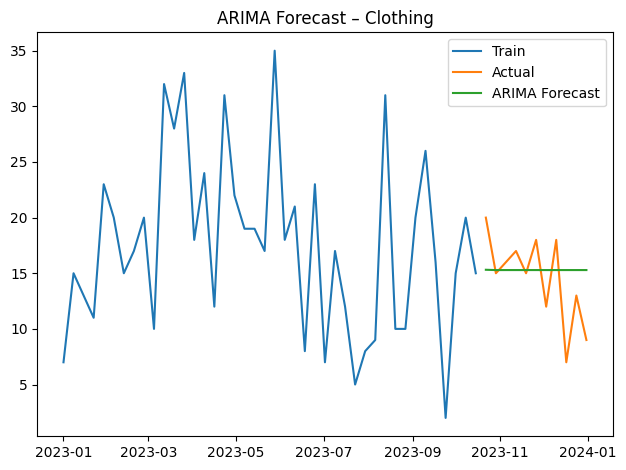

In [29]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.legend()
plt.title('ARIMA Forecast – Clothing')
plt.tight_layout()
plt.show()

In [31]:
arima_model2 = ARIMA(train, order=(2,1,2))
arima_fit2 = arima_model2.fit()
arima_forecast2 = arima_fit2.forecast(len(test))

arima_mae2 = mean_absolute_error(test, arima_forecast2)
arima_rmse2 = np.sqrt(mean_squared_error(test, arima_forecast2))

arima_mae2, arima_rmse2

(3.0073291137349516, np.float64(3.85964148030854))

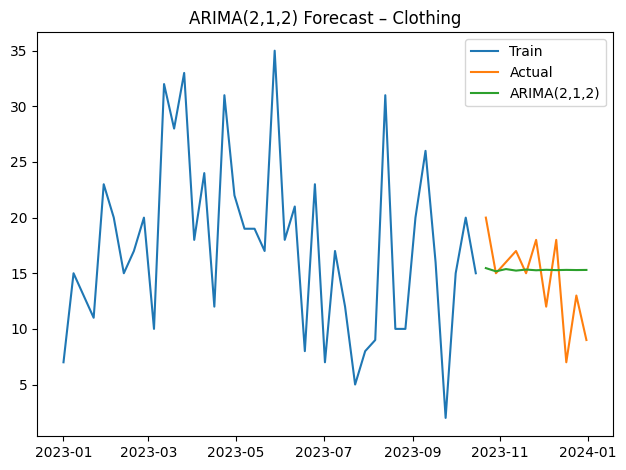

In [32]:
plt.figure()
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, arima_forecast2, label='ARIMA(2,1,2)')
plt.legend()
plt.title('ARIMA(2,1,2) Forecast – Clothing')
plt.tight_layout()
plt.show()

In [34]:
# buat series moving average lagi (kalau belum ada)
ts = clothing_weekly

ts_ma = ts.rolling(window=4).mean()

# ambil nilai MA di periode test saja
ma_forecast = ts_ma[train_size:]

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_ma = mean_absolute_error(test, ma_forecast)
rmse_ma = np.sqrt(mean_squared_error(test, ma_forecast))

mae_ma, rmse_ma

(2.1363636363636362, np.float64(2.800162332956625))

In [36]:
comparison = pd.DataFrame({
    "Model": [
        "Moving Average (4-week)",
        "Exponential Smoothing",
        "ARIMA(1,1,1)",
        "ARIMA(2,1,2)"
    ],
    "MAE": [mae_ma, mae, arima_mae, arima_mae2],
    "RMSE": [rmse_ma, rmse, arima_rmse, arima_rmse2]
})

comparison

,Model,MAE,RMSE
0,Moving Average (4-week),2.136364,2.800162
1,Exponential Smoothing,2.855915,3.581617
2,"ARIMA(1,1,1)",3.023443,3.867400
3,"ARIMA(2,1,2)",3.007329,3.859641


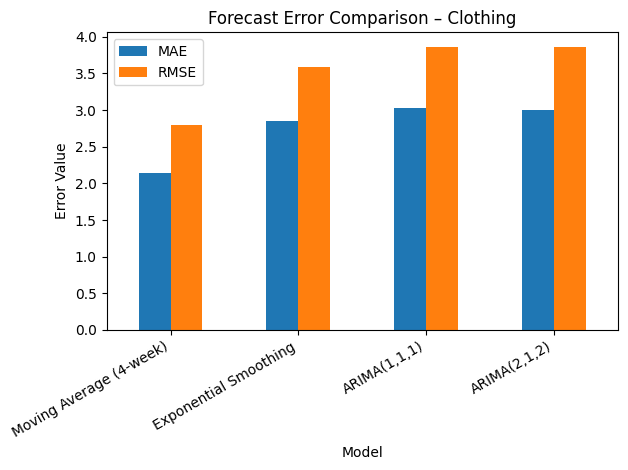

In [37]:
comparison.set_index("Model")[["MAE","RMSE"]].plot(kind="bar")
plt.title("Forecast Error Comparison – Clothing")
plt.ylabel("Error Value")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()